In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import keras
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.utils import plot_model

# Supress info, warnings and error messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
disease_types = ['COVID', 'Normal', 'Viral Pneumonia']

train_dir = data_dir = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'

train_data = []

for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])
        
train = pd.DataFrame(train_data, columns = ['File', 'ID','Disease Type'])
train

,File,ID,Disease Type
0,COVID/COVID-2116.png,0,COVID
1,COVID/COVID-2051.png,0,COVID
2,COVID/COVID-1888.png,0,COVID
3,COVID/COVID-2194.png,0,COVID
4,COVID/COVID-1840.png,0,COVID
...,...,...,...
6047,Viral Pneumonia/Viral Pneumonia-55.png,2,Viral Pneumonia
6048,Viral Pneumonia/Viral Pneumonia-1232.png,2,Viral Pneumonia
6049,Viral Pneumonia/Viral Pneumonia-1281.png,2,Viral Pneumonia
6050,Viral Pneumonia/Viral Pneumonia-493.png,2,Viral Pneumonia


,File,ID,Disease Type
0,Viral Pneumonia/Viral Pneumonia-657.png,2,Viral Pneumonia
1,COVID/COVID-749.png,0,COVID
2,COVID/COVID-2258.png,0,COVID
3,Normal/Normal-2942.png,1,Normal
4,Normal/Normal-2480.png,1,Normal
...,...,...,...
6047,Viral Pneumonia/Viral Pneumonia-471.png,2,Viral Pneumonia
6048,Normal/Normal-2474.png,1,Normal
6049,Viral Pneumonia/Viral Pneumonia-90.png,2,Viral Pneumonia
6050,Normal/Normal-1832.png,1,Normal


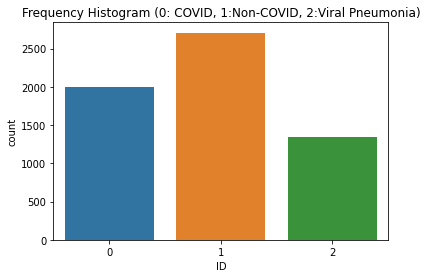

In [4]:
Seed = 40

train = train.sample(frac = 1, replace=False, random_state = Seed)

# Reset indices (row numbers)
train = train.reset_index(drop = True)

sns.countplot(x = "ID", data = train).set_title("Frequency Histogram (0: COVID, 1:Non-COVID, 2:Viral Pneumonia)")
train

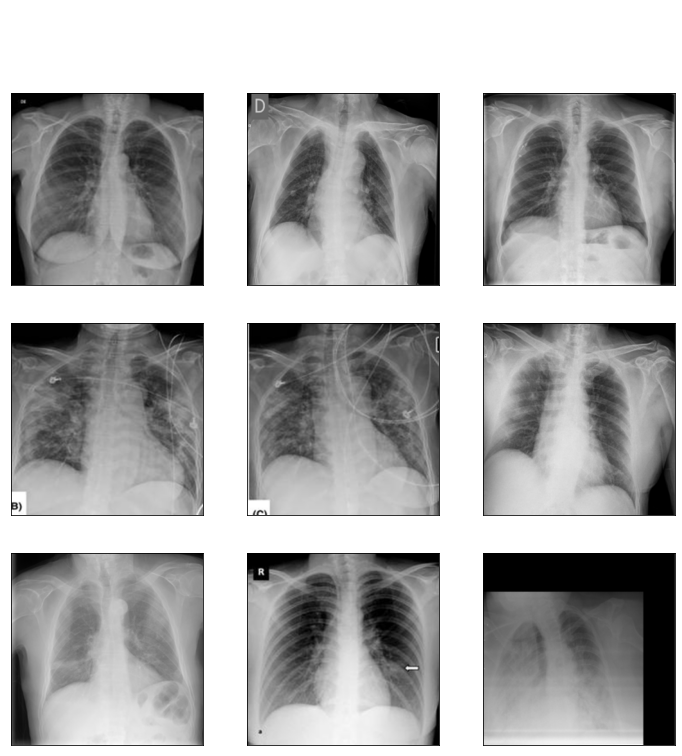

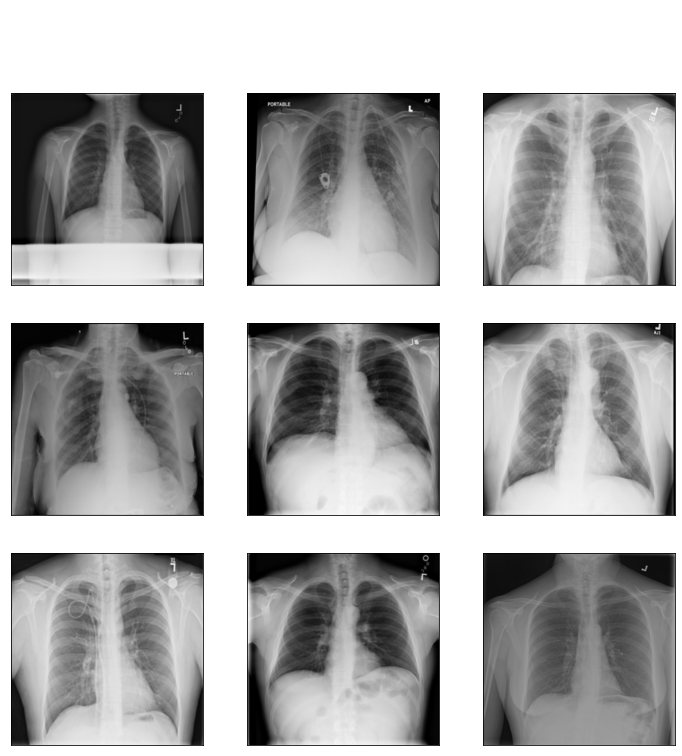

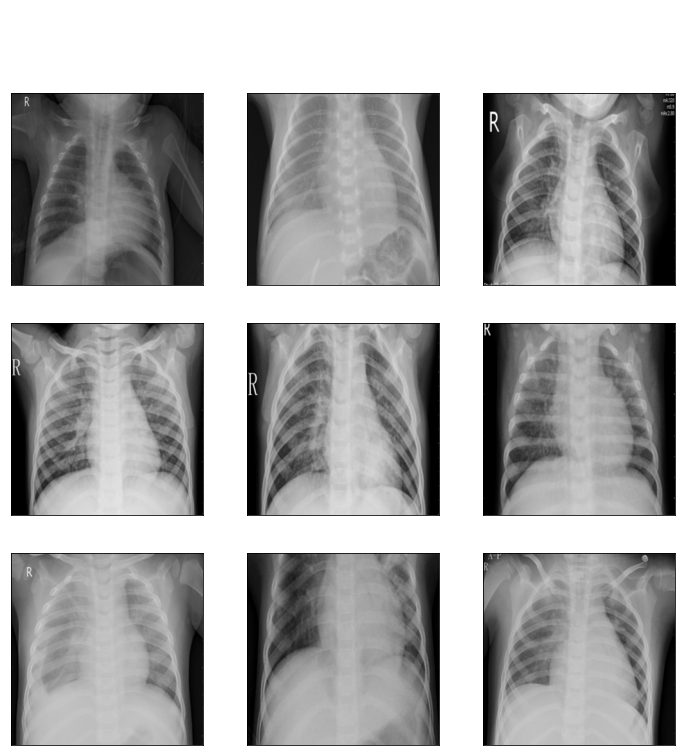

In [5]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    
    n = 0
    fig.suptitle(defect_types, fontsize = 22, color = "white")
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('COVID', 3, 3)
plot_defects('Normal', 3, 3)
plot_defects('Viral Pneumonia', 3, 3)

In [6]:
IMAGE_SIZE = 224

# OpenCV Function to load colored image
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

# OpenCV Function to resize an image
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [7]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_Train = X_train / 255.0   # Pixel normalization
print('Train Shape:', X_Train.shape)

Y_train = to_categorical(train['ID'].values, num_classes = 3)

print(Y_train)

Train Shape: (6052, 224, 224, 3)
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [8]:
# Dataframe split to train and validation set (80% train and 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_Train,
                                                  Y_train,
                                                  test_size = 0.2, # Percent 20% of the data is using as test set
                                                  random_state = Seed)

print(f'X_train:', X_train.shape)
print(f'X_val:', X_val.shape)
print(f'Y_train:', Y_train.shape)
print(f'Y_val:', Y_val.shape)

X_train: (4841, 224, 224, 3)
X_val: (1211, 224, 224, 3)
Y_train: (4841, 3)
Y_val: (1211, 3)


# ***DenseNet169***

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.applications import DenseNet169

In [ ]:
# Architectural function for DenseNet-169
def build_desnet169(IMAGE_SIZE, channels):

    densetnet169 = DenseNet169(weights = 'imagenet', include_top = False)

    input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding = 'same')(input)
    x = densetnet169(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
    
    output = Dense(3, activation = 'softmax')(x)
 
    # model
    model = Model(input, output)
    
    optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'categorical_crossentropy',  # minimize the negative multinomial log-likelihood also known as the cross-entropy.
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    model.summary()
    
    return model

51877672/51877672 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1664)             6656      
 ormalization)                                                   
                                                              

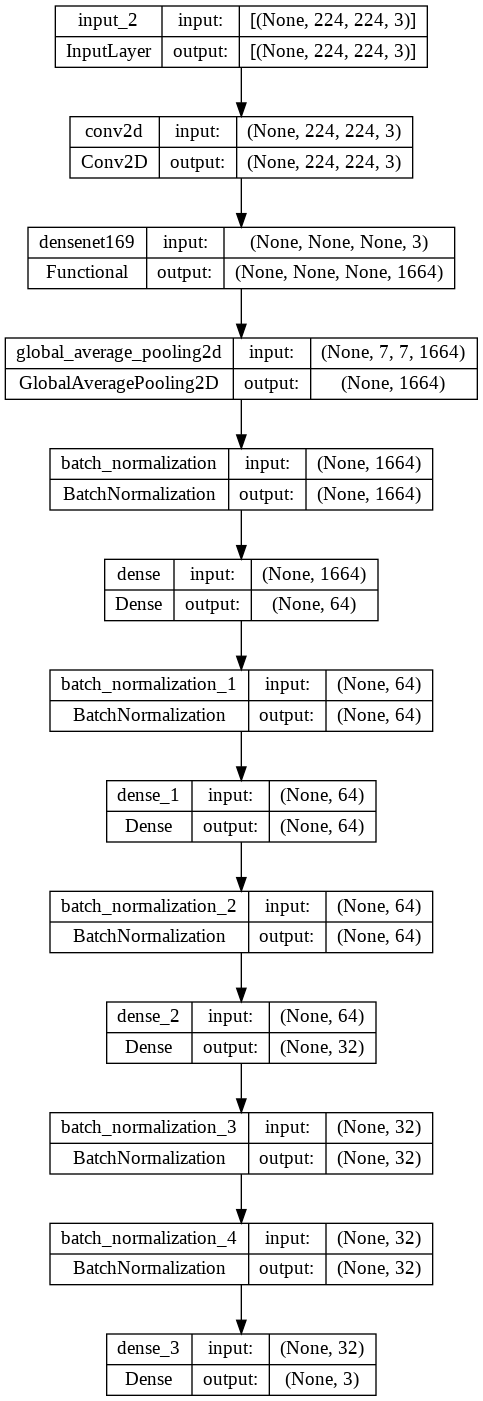

In [ ]:
channels = 3

model = build_desnet169(IMAGE_SIZE, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy',  # Reduce learning rate when Validation accuracy remains constant
                             factor = 0.70,  # Rate by which the learning rate will decrease
                             patience = 5,   # number of epochs without improvement, after which the learning rate will decrease
                             verbose = 1,    # Display messages
                             min_lr = 1e-4   # lower limit on the learning rate.
                            )
checkpoint = ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)  # Save neural network weights

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2,   # Range for random horizontal shifts
                        height_shift_range = 0.2,  # Range for random vertical shifts
                        zoom_range = 0.2,          # Range for random zoom
                        horizontal_flip = True,    # Randomly flip inputs horizontally
                        vertical_flip = True)      # Randomly flip inputs vertically

datagen.fit(X_train)
datagen.fit(X_val)

plot_model(model, to_file = 'convnet.png', show_shapes = True, show_layer_names = True)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 100
# Fit of the model that includes the augmented images in terms of their characteristics
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
               steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [annealer, checkpoint],
               validation_data = (X_val, Y_val))

Epoch 1/100
151/151 [==============================] - ETA: 0s - loss: 0.7664 - accuracy: 0.6769
Epoch 1: val_loss improved from inf to 0.70185, saving model to model.h5
151/151 [==============================] - 115s 548ms/step - loss: 0.7664 - accuracy: 0.6769 - val_loss: 0.7019 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 2/100
151/151 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.8422
Epoch 2: val_loss improved from 0.70185 to 0.50467, saving model to model.h5
151/151 [==============================] - 74s 488ms/step - loss: 0.4286 - accuracy: 0.8422 - val_loss: 0.5047 - val_accuracy: 0.8258 - lr: 0.0010
Epoch 3/100
151/151 [==============================] - ETA: 0s - loss: 0.3264 - accuracy: 0.8844
Epoch 3: val_loss improved from 0.50467 to 0.46115, saving model to model.h5
151/151 [==============================] - 74s 489ms/step - loss: 0.3264 - accuracy: 0.8844 - val_loss: 0.4611 - val_accuracy: 0.8216 - lr: 0.0010
Epoch 4/100
151/151 [===================

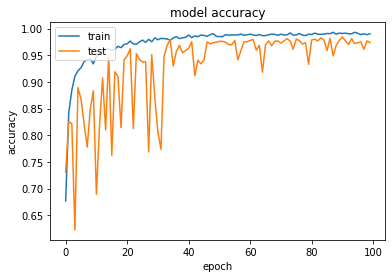

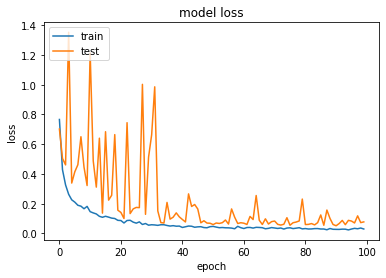

In [ ]:
from matplotlib import pyplot as plt
# Accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

1/1 [==============================] - 3s 3s/step
[9.9970609e-01 5.4481279e-06 2.8840793e-04]


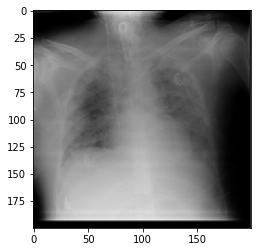

Prediction: Covid


In [ ]:
img = keras.utils.load_img('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/COVID-1095.png', grayscale = False, target_size = (IMAGE_SIZE, IMAGE_SIZE))
show_img = keras.utils.load_img('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/COVID-1095.png', grayscale = False, target_size = (200, 200))
disease_class = ['Covid','Normal','Viral Pneumonia']
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a = custom[0]
ind = np.argmax(a)
        
print('Prediction:',disease_class[ind])

38/38 [==============================] - 4s 114ms/step
True Positive: 510
False Negative: 11
True Negative: 396
False Positive: 4
True Positive Rate: 0.9788867562380038
True Negative Rate: 0.99

38/38 [==============================] - 5s 119ms/step - loss: 0.0779 - accuracy: 0.9736

Final Loss: 0.07791537046432495, Final Accuracy: 0.9735755324363708


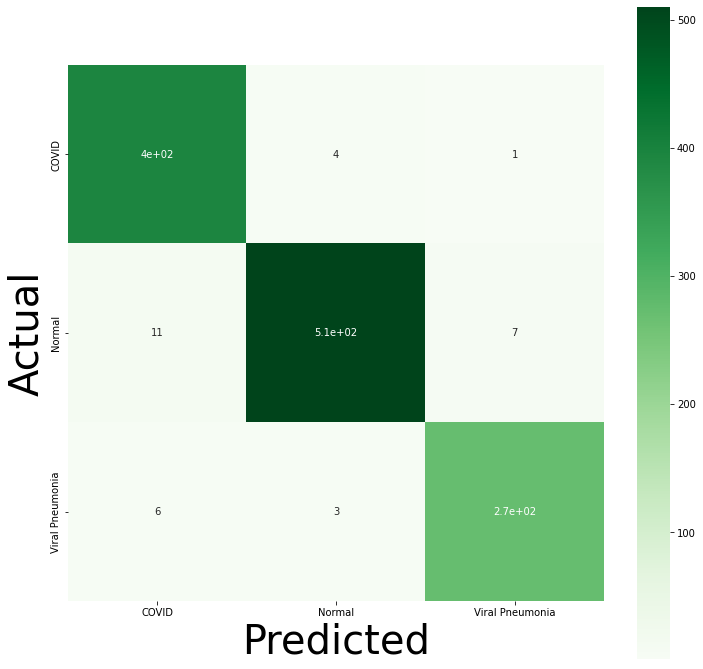

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize = (12, 12))
ax = sns.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True, xticklabels = disease_types, yticklabels = disease_types)
ax.set_ylabel('Actual', fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)


TP = cm[1][1]
print(f"True Positive: {TP}")


FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print(f"\nFinal Loss: {final_loss}, Final Accuracy: {final_accuracy}")

In [ ]:
model.save('saved_model/model1.hdf5')

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('saved_model/model1.hdf5')

In [ ]:
testX_arg = np.argmax(X_val, axis=1)
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(Y_val, axis=1)
accuracy1 = accuracy_score(y_true, y_pred)
print(accuracy1)
print(y_pred.shape)

38/38 [==============================] - 4s 116ms/step
0.9735755573905863
(1211,)


In [ ]:
print('Accuracy Score for model1 = ', accuracy1)

Accuracy Score for model1 =  0.9735755573905863


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       401
           1       0.99      0.97      0.98       528
           2       0.97      0.97      0.97       282

    accuracy                           0.97      1211
   macro avg       0.97      0.97      0.97      1211
weighted avg       0.97      0.97      0.97      1211



# ***Xception***

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.applications import Xception

In [ ]:
# Architectural function for DenseNet-169
def build_xception(IMAGE_SIZE, channels):

    xception = Xception(weights = 'imagenet', include_top = False)

    input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding = 'same')(input)
    x = xception(x)
    x = GlobalAveragePooling2D()(x)
    x =tf.keras.layers.Dropout(0.50)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation = 'relu')(x)
    x =tf.keras.layers.Dropout(0.50)(x)
    x = Dense(128, activation = 'relu')(x)
    x =tf.keras.layers.Dropout(0.50)(x)
    x = Dense(64, activation = 'relu')(x)
    x =tf.keras.layers.Dropout(0.50)(x)
    x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
    
    output = Dense(3, activation = 'softmax')(x)
 
    # model
    model = Model(input, output)
    
    optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'categorical_crossentropy',  # minimize the negative multinomial log-likelihood also known as the cross-entropy.
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    model.summary()
    
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 3)       84        
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                             

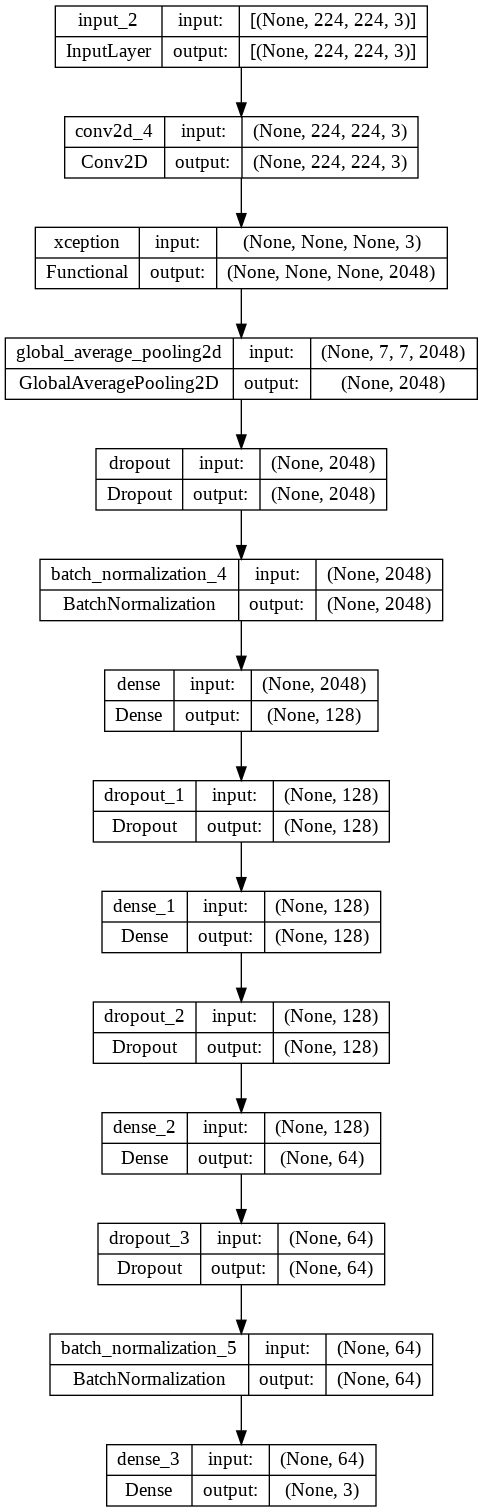

In [ ]:
channels = 3

model = build_xception(IMAGE_SIZE, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy',  # Reduce learning rate when Validation accuracy remains constant
                             factor = 0.70,  # Rate by which the learning rate will decrease
                             patience = 5,   # number of epochs without improvement, after which the learning rate will decrease
                             verbose = 1,    # Display messages
                             min_lr = 1e-4   # lower limit on the learning rate.
                            )
checkpoint = ModelCheckpoint('model2.h5', verbose = 1, save_best_only = True)  # Save neural network weights

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2,   # Range for random horizontal shifts
                        height_shift_range = 0.2,  # Range for random vertical shifts
                        zoom_range = 0.2,          # Range for random zoom
                        horizontal_flip = True,    # Randomly flip inputs horizontally
                        vertical_flip = True)      # Randomly flip inputs vertically


datagen.fit(X_train)
datagen.fit(X_val)

plot_model(model, to_file = 'convnet.png', show_shapes = True, show_layer_names = True)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 65

# Fit of the model that includes the augmented images in terms of their characteristics
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
               steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [annealer, checkpoint],
               validation_data = (X_val, Y_val))

Epoch 1/65
151/151 [==============================] - ETA: 0s - loss: 1.5211 - accuracy: 0.3502
Epoch 1: val_loss improved from inf to 1.05286, saving model to model2.h5
151/151 [==============================] - 130s 724ms/step - loss: 1.5211 - accuracy: 0.3502 - val_loss: 1.0529 - val_accuracy: 0.4591 - lr: 0.0010
Epoch 2/65
151/151 [==============================] - ETA: 0s - loss: 1.3543 - accuracy: 0.3920
Epoch 2: val_loss improved from 1.05286 to 0.96328, saving model to model2.h5
151/151 [==============================] - 104s 690ms/step - loss: 1.3543 - accuracy: 0.3920 - val_loss: 0.9633 - val_accuracy: 0.5549 - lr: 0.0010
Epoch 3/65
151/151 [==============================] - ETA: 0s - loss: 1.1158 - accuracy: 0.5045
Epoch 3: val_loss improved from 0.96328 to 0.74786, saving model to model2.h5
151/151 [==============================] - 104s 689ms/step - loss: 1.1158 - accuracy: 0.5045 - val_loss: 0.7479 - val_accuracy: 0.7102 - lr: 0.0010
Epoch 4/65
151/151 [==================

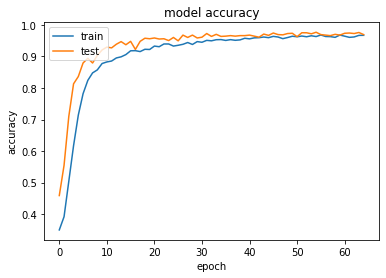

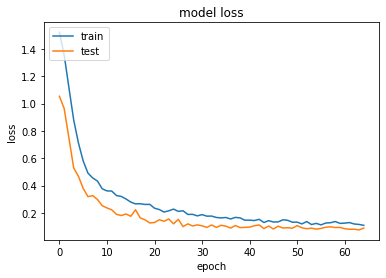

In [ ]:
from matplotlib import pyplot as plt
# Accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

1/1 [==============================] - 1s 1s/step
[9.9845076e-01 8.2008686e-04 7.2917918e-04]


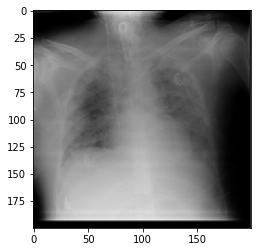

Prediction: Covid


In [ ]:
img = keras.utils.load_img('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/COVID-1095.png', grayscale = False, target_size = (IMAGE_SIZE, IMAGE_SIZE))
show_img = keras.utils.load_img('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/COVID-1095.png', grayscale = False, target_size = (200, 200))
disease_class = ['Covid','Normal','Viral Pneumonia']
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a = custom[0]
ind = np.argmax(a)
        
print('Prediction:',disease_class[ind])

38/38 [==============================] - 5s 139ms/step
True Positive: 509
False Negative: 16
True Negative: 394
False Positive: 6
True Positive Rate: 0.9695238095238096
True Negative Rate: 0.985

38/38 [==============================] - 5s 141ms/step - loss: 0.0895 - accuracy: 0.9694

Final Loss: 0.08950220793485641, Final Accuracy: 0.9694467186927795


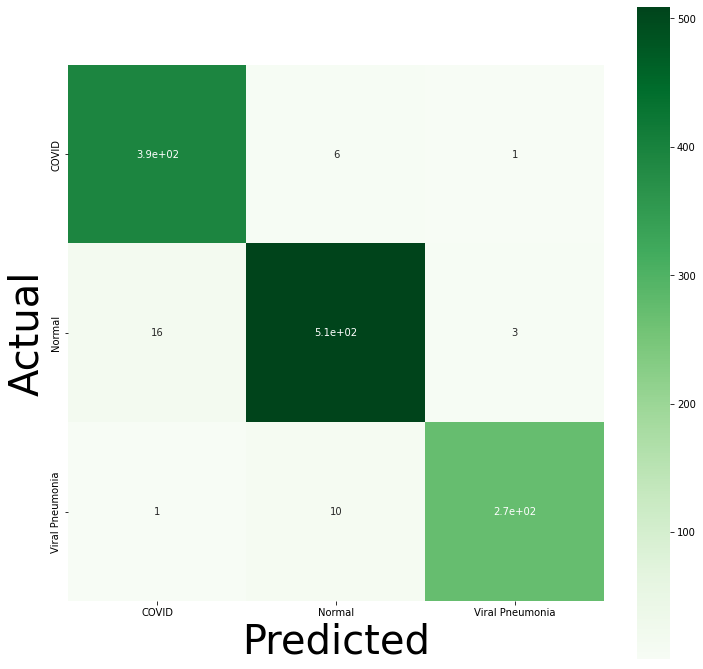

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize = (12, 12))
ax = sns.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True, xticklabels = disease_types, yticklabels = disease_types)
ax.set_ylabel('Actual', fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)


TP = cm[1][1]
print(f"True Positive: {TP}")


FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print(f"\nFinal Loss: {final_loss}, Final Accuracy: {final_accuracy}")

In [ ]:
model.save('saved_model/model2.hdf5')

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('saved_model/model2.hdf5')

In [ ]:
testX_arg = np.argmax(X_val, axis=1)
y_pred = np.argmax(model1.predict(X_val), axis=1)
y_true = np.argmax(Y_val, axis=1)
accuracy1 = accuracy_score(y_true, y_pred)
print(accuracy1)
print(y_pred.shape)

38/38 [==============================] - 6s 138ms/step
0.9694467382328654
(1211,)


In [ ]:
print('Accuracy Score for model2 = ', accuracy1)

Accuracy Score for model2 =  0.9694467382328654


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       401
           1       0.97      0.96      0.97       528
           2       0.99      0.96      0.97       282

    accuracy                           0.97      1211
   macro avg       0.97      0.97      0.97      1211
weighted avg       0.97      0.97      0.97      1211



# ***VGG16***

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.applications import VGG16

In [ ]:
# Architectural function for DenseNet-169
def build_vgg16(IMAGE_SIZE, channels):

    vgg16 = VGG16(weights = 'imagenet', include_top = False)

    input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding = 'same')(input)
    x = vgg16(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
    
    output = Dense(3, activation = 'softmax')(x)
 
    # model
    model = Model(input, output)
    
    optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'categorical_crossentropy',  # minimize the negative multinomial log-likelihood also known as the cross-entropy.
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    model.summary()
    
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               65664 

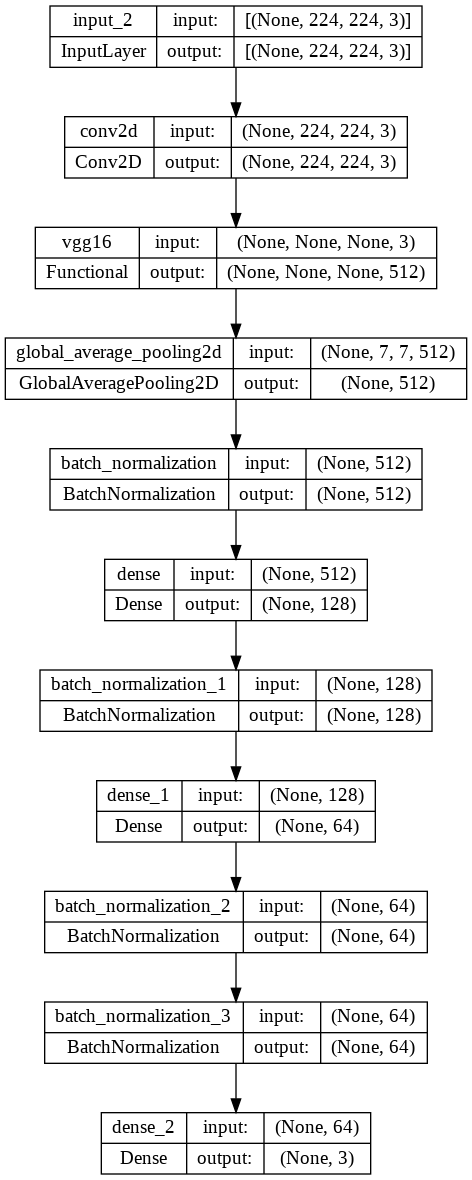

In [ ]:
channels = 3

model = build_vgg16(IMAGE_SIZE, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy',  # Reduce learning rate when Validation accuracy remains constant
                             factor = 0.70,  # Rate by which the learning rate will decrease
                             patience = 5,   # number of epochs without improvement, after which the learning rate will decrease
                             verbose = 1,    # Display messages
                             min_lr = 1e-4   # lower limit on the learning rate.
                            )
checkpoint = ModelCheckpoint('model3.h5', verbose = 1, save_best_only = True)  # Save neural network weights

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2,   # Range for random horizontal shifts
                        height_shift_range = 0.2,  # Range for random vertical shifts
                        zoom_range = 0.2,          # Range for random zoom
                        horizontal_flip = True,    # Randomly flip inputs horizontally
                        vertical_flip = True)      # Randomly flip inputs vertically

datagen.fit(X_train)
datagen.fit(X_val)

plot_model(model, to_file = 'convnet.png', show_shapes = True, show_layer_names = True)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 100

# Fit of the model that includes the augmented images in terms of their characteristics
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
               steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [annealer, checkpoint],
               validation_data = (X_val, Y_val))

Epoch 1/100
151/151 [==============================] - ETA: 0s - loss: 1.0076 - accuracy: 0.5669
Epoch 1: val_loss improved from inf to 2.83952, saving model to model3.h5
151/151 [==============================] - 105s 557ms/step - loss: 1.0076 - accuracy: 0.5669 - val_loss: 2.8395 - val_accuracy: 0.3311 - lr: 0.0010
Epoch 2/100
151/151 [==============================] - ETA: 0s - loss: 0.7257 - accuracy: 0.6970
Epoch 2: val_loss did not improve from 2.83952
151/151 [==============================] - 77s 508ms/step - loss: 0.7257 - accuracy: 0.6970 - val_loss: 3.5226 - val_accuracy: 0.3303 - lr: 0.0010
Epoch 3/100
145/151 [===========================>..] - ETA: 2s - loss: 0.5835 - accuracy: 0.7548
Epoch 3: val_loss improved from 2.83952 to 1.17519, saving model to model3.h5
151/151 [==============================] - 78s 513ms/step - loss: 0.5809 - accuracy: 0.7559 - val_loss: 1.1752 - val_accuracy: 0.4855 - lr: 0.0010
Epoch 4/100
151/151 [==============================] - ETA: 0s - los

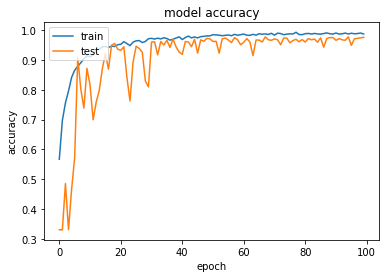

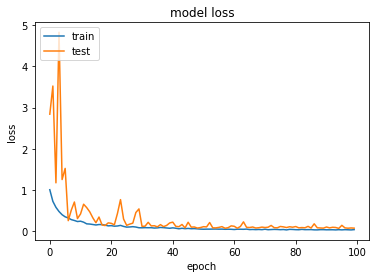

In [ ]:
from matplotlib import pyplot as plt
# Accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

1/1 [==============================] - 1s 924ms/step
[9.9964654e-01 1.3719242e-05 3.3971563e-04]


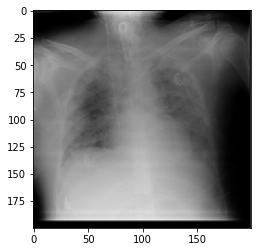

Prediction: Covid


In [ ]:
img = keras.utils.load_img('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/COVID-1095.png', grayscale = False, target_size = (IMAGE_SIZE, IMAGE_SIZE))
show_img = keras.utils.load_img('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/COVID-1095.png', grayscale = False, target_size = (200, 200))
disease_class = ['Covid','Normal','Viral Pneumonia']
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a = custom[0]
ind = np.argmax(a)
        
print('Prediction:',disease_class[ind])

38/38 [==============================] - 6s 164ms/step
True Positive: 515
False Negative: 6
True Negative: 392
False Positive: 9
True Positive Rate: 0.9884836852207294
True Negative Rate: 0.9775561097256857

38/38 [==============================] - 6s 165ms/step - loss: 0.0761 - accuracy: 0.9752

Final Loss: 0.0760979875922203, Final Accuracy: 0.9752270579338074


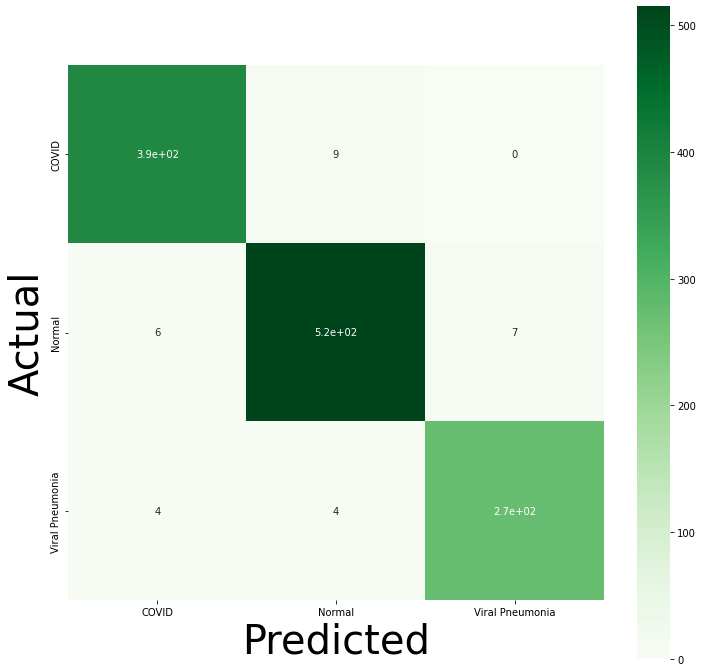

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize = (12, 12))
ax = sns.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True, xticklabels = disease_types, yticklabels = disease_types)
ax.set_ylabel('Actual', fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)


TP = cm[1][1]
print(f"True Positive: {TP}")


FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print(f"\nFinal Loss: {final_loss}, Final Accuracy: {final_accuracy}")

In [ ]:
model.save('saved_model/model3.hdf5')

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

model2 = load_model('saved_model/model3.hdf5')

In [ ]:
testX_arg = np.argmax(X_val, axis=1)
y_pred = np.argmax(model2.predict(X_val), axis=1)
y_true = np.argmax(Y_val, axis=1)
accuracy1 = accuracy_score(y_true, y_pred)
print(accuracy1)
print(y_pred.shape)

38/38 [==============================] - 6s 167ms/step
0.9752270850536746
(1211,)


In [ ]:
print('Accuracy Score for model3 = ', accuracy1)

Accuracy Score for model3 =  0.9752270850536746


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       401
           1       0.98      0.98      0.98       528
           2       0.98      0.97      0.97       282

    accuracy                           0.98      1211
   macro avg       0.98      0.97      0.98      1211
weighted avg       0.98      0.98      0.98      1211



# ***Ensemble***

In [12]:
from keras.models import load_model
from sklearn.metrics import accuracy_score


In [13]:
model1 = load_model('pd/model1.hdf5')
model2 = load_model('pd/model2.hdf5')
model3 = load_model('pd/model3.hdf5')

models = [model1, model2, model3]

In [14]:
preds = [model.predict(X_val) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

38/38 [==============================] - 12s 233ms/step


In [15]:
# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

In [17]:
testX_arg = np.argmax(X_val, axis=1)
y_true = np.argmax(Y_val, axis=1)
accuracy1 = accuracy_score(y_true, ensemble_prediction)
print("Ensemble Accuracy:")
print(accuracy1)

Ensemble Accuracy:
0.9843104872006606


In [18]:
testX_arg1 = np.argmax(X_val, axis=1)
y_pred1 = np.argmax(model1.predict(X_val), axis=1)
y_true1 = np.argmax(Y_val, axis=1)
accuracy1 = accuracy_score(y_true1, y_pred1)


testX_arg2 = np.argmax(X_val, axis=1)
y_pred2 = np.argmax(model2.predict(X_val), axis=1)
y_true2 = np.argmax(Y_val, axis=1)
accuracy2 = accuracy_score(y_true2, y_pred2)


testX_arg3 = np.argmax(X_val, axis=1)
y_pred3 = np.argmax(model3.predict(X_val), axis=1)
y_true3 = np.argmax(Y_val, axis=1)
accuracy3 = accuracy_score(y_true3, y_pred3)

38/38 [==============================] - 6s 167ms/step


In [19]:
testX_arg = np.argmax(X_val, axis=1)
y_true4 = np.argmax(Y_val, axis=1)
accuracy4 = accuracy_score(y_true4, ensemble_prediction)
print("Ensemble Accuracy:")
print(accuracy4)

Ensemble Accuracy:
0.9843104872006606


In [20]:
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for Ensemble = ', accuracy4)

Accuracy Score for model1 =  0.9735755573905863
Accuracy Score for model2 =  0.9694467382328654
Accuracy Score for model3 =  0.9752270850536746
Accuracy Score for Ensemble =  0.9843104872006606


In [21]:
testX_arg = np.argmax(X_val, axis=1)
y_true4 = np.argmax(Y_val, axis=1)
accuracy4 = accuracy_score(y_true4, ensemble_prediction)
print("Ensemble Accuracy:")
print(accuracy4)

Ensemble Accuracy:
0.9843104872006606


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_true4, ensemble_prediction))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       401
           1       0.99      0.98      0.98       528
           2       0.98      0.98      0.98       282

    accuracy                           0.98      1211
   macro avg       0.98      0.98      0.98      1211
weighted avg       0.98      0.98      0.98      1211



True Positive: 518
False Negative: 4
True Negative: 397
False Positive: 4
True Positive Rate: 0.9923371647509579
True Negative Rate: 0.9900249376558603



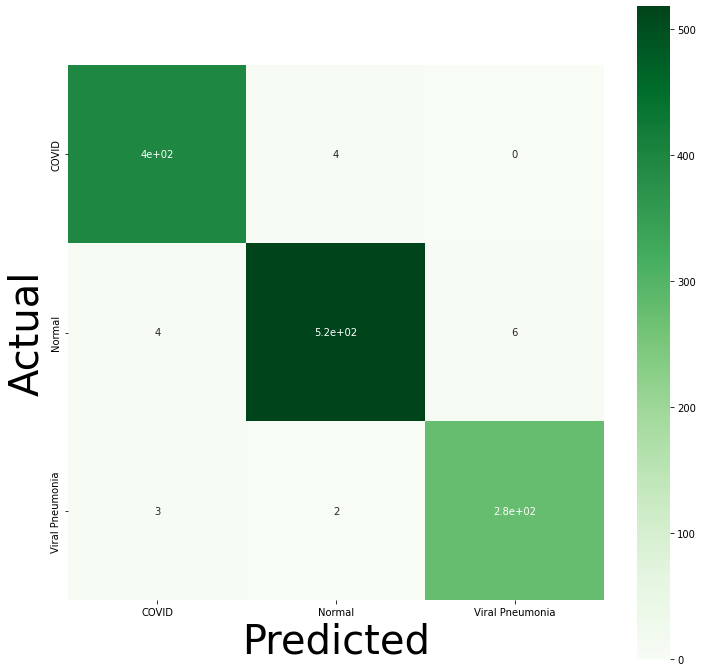

In [23]:
cm = confusion_matrix(y_true4, ensemble_prediction)
plt.figure(figsize = (12, 12))
ax = sns.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True, xticklabels = disease_types, yticklabels = disease_types)
ax.set_ylabel('Actual', fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)


TP = cm[1][1]
print(f"True Positive: {TP}")


FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")

In [32]:
models = [model1, model2, model3]
preds = [model.predict(X_val) for model in models]
preds=np.array(preds)
weights = [0.3, 0.4, 0.2]

38/38 [==============================] - 6s 173ms/step


In [33]:
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
y_true = np.argmax(Y_val, axis=1)
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(y_true, weighted_ensemble_prediction)

In [34]:
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', accuracy4)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.9735755573905863
Accuracy Score for model2 =  0.9694467382328654
Accuracy Score for model3 =  0.9752270850536746
Accuracy Score for average ensemble =  0.9843104872006606
Accuracy Score for weighted average ensemble =  0.985962014863749


In [29]:
models = [model1, model2, model3]
preds1 = [model.predict(X_val) for model in models]
preds1=np.array(preds1)
y_true = np.argmax(Y_val, axis=1)
import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10., w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(y_true, wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
  

38/38 [==============================] - 7s 163ms/step


In [30]:
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[0], " obained with w1=", max_acc_row[1], " w2=", max_acc_row[2], " and w3=", max_acc_row[3])  

Max accuracy of  0.2  obained with w1= 0.3  w2= 0.2  and w3= 98.67877786952931


In [31]:
df.style

,wt1,wt2,wt3,acc
0,0.000000,0.000000,0.000000,33.113130
1,0.000000,0.000000,0.100000,97.522709
2,0.000000,0.000000,0.200000,97.522709
3,0.000000,0.000000,0.300000,97.522709
4,0.000000,0.000000,0.400000,97.522709
5,0.000000,0.100000,0.000000,96.944674
6,0.000000,0.100000,0.100000,98.348472
7,0.000000,0.100000,0.200000,98.183320
8,0.000000,0.100000,0.300000,98.100743
9,0.000000,0.100000,0.400000,98.100743
